# Kramer Problem Instanton Calculation 

In this notebook we will use the MAM method outlined in [1] to calculate an instanton in the Kramer problem. We will compare this to the analytic solution as well as the numerically integrated Euler-Lagrange Equations.

- [1] Weinan, E., Ren, W. and Vanden-Eijnden, E., 2004. Minimum action method for the study of rare events. Communications on pure and applied mathematics, 57(5), pp.637-656.

In [19]:
# Standard Package imports

import numpy as np
import numpy.linalg as la
import numpy.random as rm
import matplotlib.pyplot as plt
import pickle

from mam import Mam_alg
from instanton_utility import *
from tqdm.notebook import tqdm

In [20]:
# Functions for saving/loading results

def save_result(result, f):
    """
    result - output from mam algorithm run
    f - filename
    """
    outfile = open(f,'wb')
    pickle.dump(result,outfile)
    outfile.close()
    print(f'Saved to {f}')

def load_result(f):
    print(f'Loading {f}')
    infile = open(f,'rb')
    return pickle.load(infile)

# Problem Definition & Parameter Choices

Here we define the drift function of the OU system and specify our parameter choices.

In [21]:
# F-W action Definition

def a(t, x, s):
    epsilon, sigma = s
    return x * (1 - x**2)

In [22]:
# Parameter Specification

# Kramer Parameters
eps = 0.01
sigma = 0.0001
s = [eps, sigma]
D = sigma **2
Dinv = 1/D

# Time
t0 = 0
tF = 25
dt = 0.1
steps = int((tF-t0)/dt)
time = np.arange(t0, tF, dt)

## MAM Set up

Here we define the initial instanton path for the minimisation problem, specify bounds and create a MAM algorithm object.

In [23]:
# Instanton Initialisation

initial_point = -1
final_point = 1

inst_ic = np.linspace(initial_point, final_point, len(time))

In [24]:
# --------------------------------------------------------------------------------
# Example Bounds Grid - Useful should you want to specify your own bounds
# --------------------------------------------------------------------------------

bnds = np.zeros((*inst_ic.shape, 2)) # indexed by Time, ndim, lower/upper

if (len(inst_ic.shape) == 1):
    shape = 1
else:
    shape = np.ones(inst_ic.shape[1])

# t = 0 Constraint
bnds[0,...,0] = initial_point - 0.001 * shape # Lower
bnds[0,...,1] = initial_point + 0.001 * shape # Upper

# Bounds for t \in (dt, T-dt)
bnds[1:-1, ..., 0] = -np.inf
bnds[1:-1, ..., 1] = np.inf

# t = T Constraint
bnds[-1,...,0] = final_point - 0.001 * shape
bnds[-1,...,1] = final_point + 0.001 * shape

In [25]:
# Object creation

# ou_mam = Mam_alg(a, s, inst_ic, time, Dinv) # default bounds
ou_mam = Mam_alg(a, s, inst_ic, time, Dinv, bnds=bnds) # specify bounds 

## Running MAM Algorithm

We run the algorithm for up to 10000 iterations/until convergence.

In [26]:
# Keep Runnning Til convergence
options={'maxiter': 10, 'maxfun': 10} 
result = ou_mam.run(options)

b'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'


In [27]:
result.status

1

In [28]:
print(f'Have run for {ou_mam.nfev} iterations')

Have run for 502 iterations


## Numerical Solution Plot

We plot the MAM output.

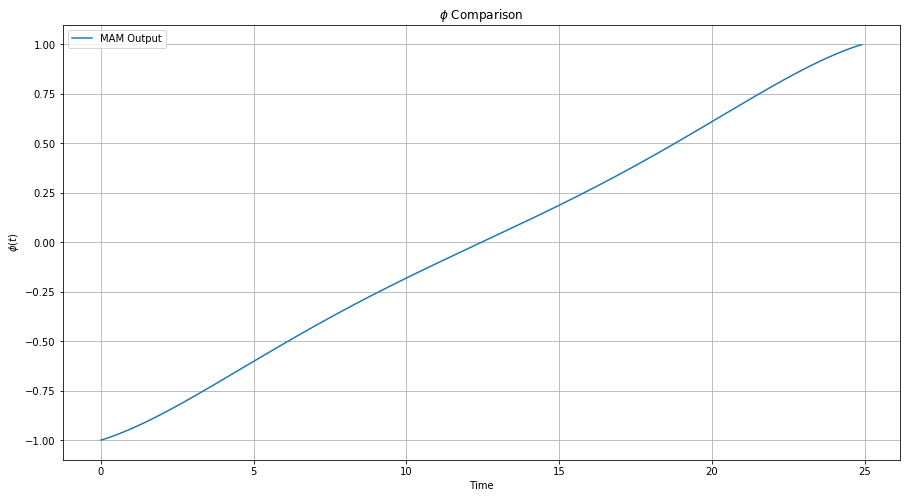

In [29]:
# Comparison Plot

fig, ax = plt.subplots(figsize=(15, 8))

ax.grid()
ax.set_title('$\\phi$ Comparison')
ax.plot(time, ou_mam.instanton, label = 'MAM Output')
ax.set_xlabel('Time')
ax.set_ylabel('$\\phi(t)$')
ax.legend()
fig.show()

## Calculating action For Nearby Paths

We compare the action for slightly perturb paths, create a histogram and check if our found path does indeed minimise.

In [30]:
# Creating A Load Of Random Paths to compare against

near_paths = [random_path(ou_mam.instanton, 0.01) for i in range(10000)] # Conclusion Different depending on paths
# near_paths = [random_path(ou_mam.instanton, 0.001) for i in range(10000)]

In [31]:
# Creating Object to Track Action Check

action_track = action_minimisation_checker(a, ou_mam.instanton, [s, time, Dinv])

In [32]:
# Doing the Comparison

for path in near_paths:
    action_track.compare(path)

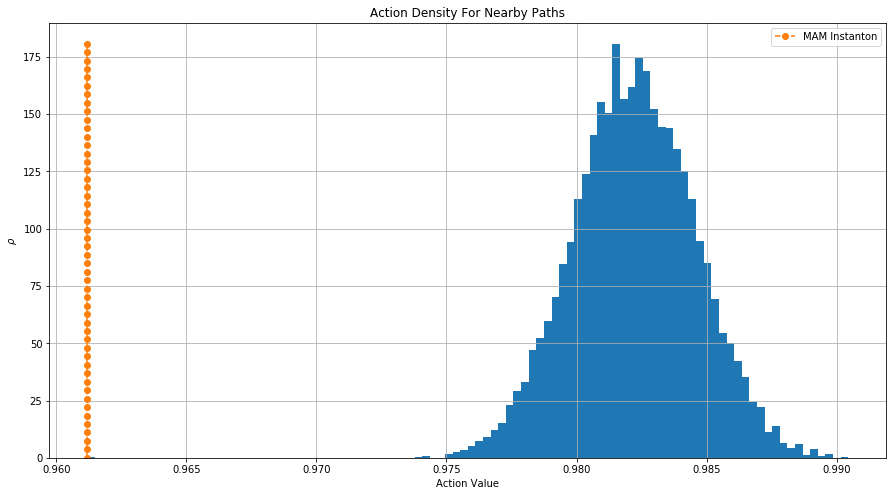

In [33]:
# Histogram 

fig, ax = plt.subplots(figsize=(15, 8))

ax.grid()
bins, edges, patches = ax.hist(action_track.av_list, bins=100, density=True)
ax.plot(np.full_like(np.linspace(0, max(bins)), action_track.action_value), 
        np.linspace(0, max(bins)), '--o', label='MAM Instanton')
ax.set_xlabel('Action Value')
ax.set_ylabel('$\\rho$')
ax.set_title('Action Density For Nearby Paths')
ax.legend()
fig.show()

## Effect of T

In [34]:
# Fixed Parameter Specification

# Kramer Parameters
eps = 0.01
sigma = 0.0001
s = [eps, sigma]
D = sigma **2
Dinv = 1/D

# Boundary Conditions
initial_point = -1
final_point = 1

#Time
t0 = 0
dt = 0.01

# BFGS Options
options={'maxiter': int(1.e6), 'maxfun': int(1.e6)} 




In [54]:
# # T-experiment Loop

# # T Choices

Ts = [1, 5, 25]

# not_converged = []

# for T in tqdm(Ts):
    
#     save_name = f'Kramer/T-experiment/T{T}'
#     print(f'Working on T = {T}')

#     # Time
#     steps = int((T-t0)/dt)
#     time = np.arange(t0, T, dt)

#     # Instanton Initialisation
#     inst_ic = np.linspace(initial_point, final_point, len(time))
#     ou_mam = Mam_alg(a, s, inst_ic, time, Dinv) # Default bounds used
    
#     # Keep Runnning Til convergence
#     result = ou_mam.run(options)
    
#     if (result.status == 0):
#         save_result(result, save_name)
        
#     else:
#         print(f'For T= {T}, did not converge in time')
#         not_converged.append(result)

In [55]:
# # T=125 done with larger dt=0.1 has odd output!

# options={'maxiter': int(2.e6), 'maxfun': int(2.e6)} 

# T = 125
# dt=0.01

# save_name = f'Kramer/T-experiment/T{T}'
# print(f'Working on T = {T}')

# # Time
# steps = int((T-t0)/dt)
# time = np.arange(t0, T, dt)

# # Instanton Initialisation
# inst_ic = np.linspace(initial_point, final_point, len(time))
# ou_mam = Mam_alg(a, s, inst_ic, time, Dinv) # Default bounds used

# # Keep Runnning Til convergence
# result = ou_mam.run(options)

# if (result.status == 0):
#     save_result(result, save_name)

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Saved to Kramer/T-experiment/T125


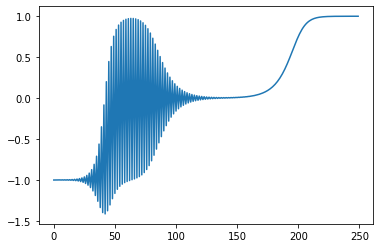

In [56]:
# Keep Runnning Til convergence
result = ou_mam.run(options)
plt.plot(result.x)

if (result.status == 0):
    save_result(result, save_name)

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Saved to Kramer/T-experiment/T125


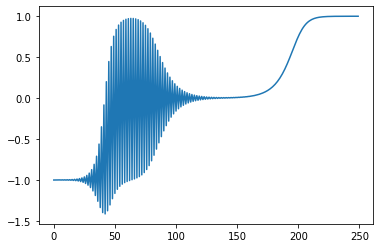

In [57]:
# Keep Runnning Til convergence
result = ou_mam.run(options)
plt.plot(result.x)

if (result.status == 0):
    save_result(result, save_name)

In [58]:
# Loading Experiment Result into a list of tuples of form (T, result)

t_experiment = []

for T in Ts:
    save_name = f'Kramer/T-experiment/T{T}'
    result = load_result(save_name)
    t_experiment.append((T, result.x))

Loading Kramer/T-experiment/T1
Loading Kramer/T-experiment/T5
Loading Kramer/T-experiment/T25


No handles with labels found to put in legend.


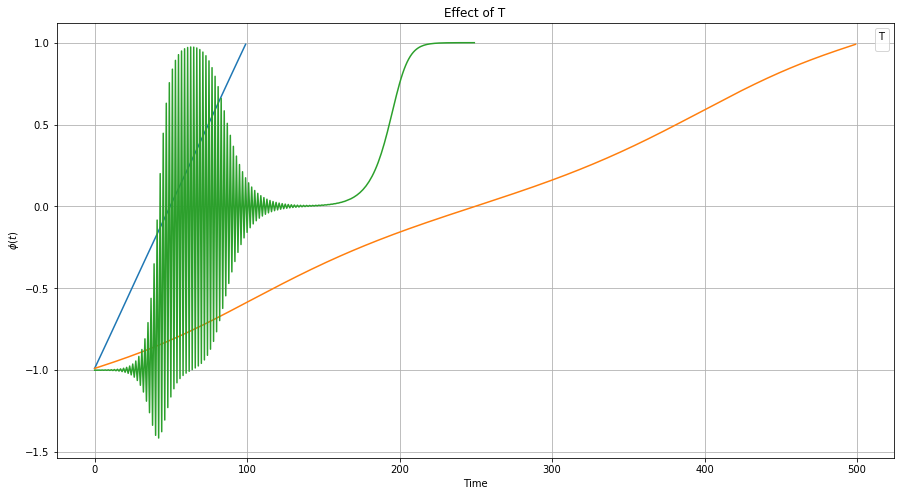

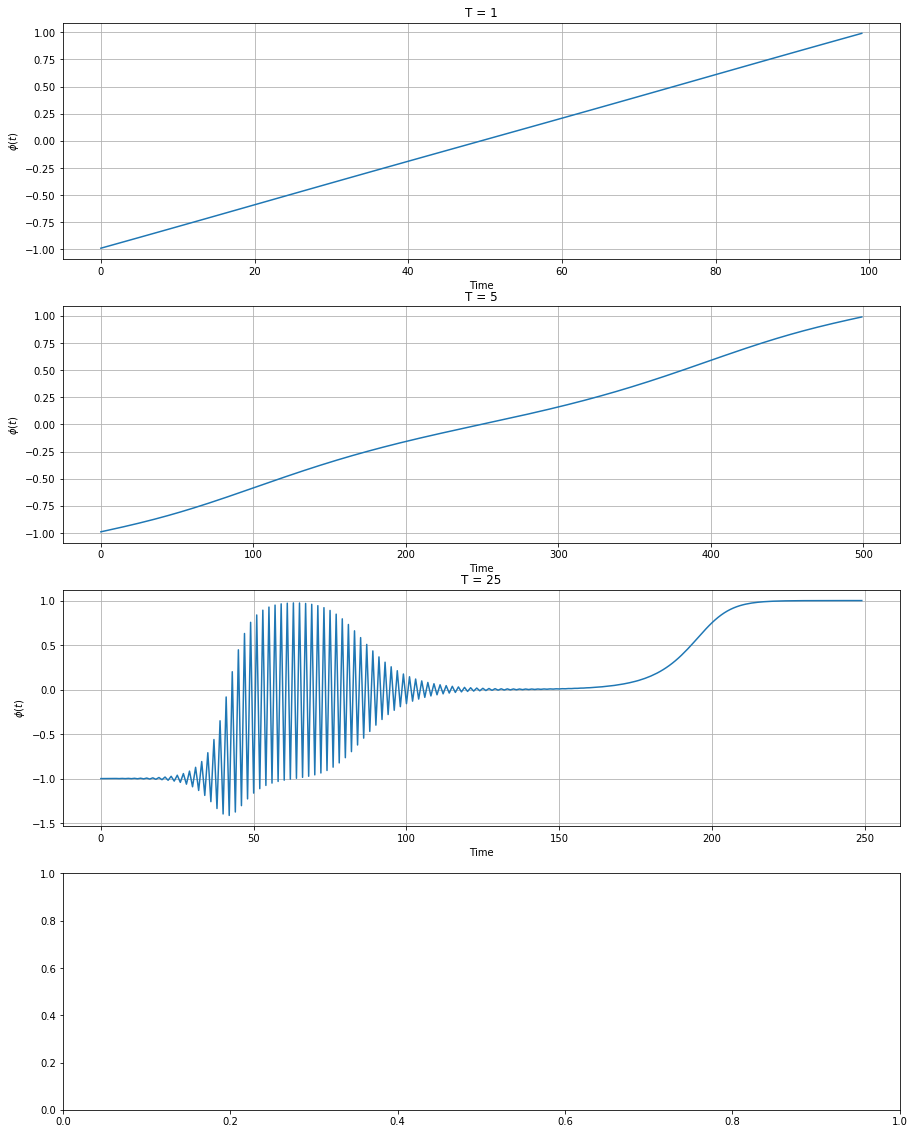

In [59]:
# Plotting Output

fig, ax = plt.subplots(figsize=(15, 8))

ax.grid()
ax.set_title('Effect of T')
ax.set_xlabel('Time')
ax.set_ylabel('$\\phi(t)$')

for (T, instanton) in t_experiment:
    time = np.arange(0, T, 0.01)
#     ax.plot(time, instanton, label=f'{T}')
    ax.plot(instanton)

ax.legend(title='T')
fig.show()

fig, axes = plt.subplots(4, 1, figsize=(15, 20))
for (ax, (T, instanton)) in zip(axes, t_experiment):
    time = np.arange(0, T, 0.01)
    ax.grid()
#     ax.plot(time, instanton)
    ax.plot(instanton)
    ax.set_title(f'T = {T}')
    ax.set_xlabel('Time')
    ax.set_ylabel('$\\phi(t)$')
fig.show()